In [2]:
## libraries to install ##
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from matplotlib.gridspec import GridSpec
from tabulate import tabulate
from pathlib import Path
import glob


import plotly.io as pio
pio.renderers.default='notebook'

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [3]:
def plot_model_results(dataframe, 
                       plot_type='violinplot',
                       x='category_new', 
                       y='roc_auc_score', 
                       hue=None, 
                       split=False,
                       title='',
                       ylim=[0.4, 1],
                       order=None,
                       hue_order=None
                      ):
    if plot_type=='violinplot':
        ax = sns.violinplot(x=x, y=y, hue=hue, split=split, data=dataframe, order=order)
    elif plot_type=='lineplot':
        ax = sns.lineplot(x=x, y=y, hue=hue, data=dataframe, err_style='bars', hue_order=hue_order)
        if order is not None:
            ax.set_xticklabels(order)
    plt.xticks(rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(title)
    plt.axhline(y=0.5, color='k', linestyle='--')
    ax.set_ylim(ylim)
    plt.show()
    

def filter_data(dataframe, columns, values_list):
    """Indexes a Pandas DataFrame using a list of columns and a list of specific values.

    Args:
    dataframe (pandas.DataFrame): The DataFrame to index.
    columns (list): A list of column names to index by.
    values_list (list): A list of specific values to match.

    Returns:
    pandas.DataFrame: The filtered DataFrame.
    """

    # Check if the number of columns and values in the lists match.
    if len(columns) != len(values_list):
        raise ValueError("The number of columns and values in the lists must match.")

    # Create a list of boolean values indicating whether each row matches the values.
    row_matches = []
    for i, column in enumerate(columns):
        if column in dataframe.columns:
            row_matches.append(list(dataframe[column].isin(values_list[i])))

    # if there are multiple columns, combine the boolean values into a single boolean value
    if len(row_matches)>0:
        if len(row_matches)>1:
            row_matches = np.all(row_matches, axis=0)
        else:
            row_matches = row_matches[0]

        # Filter the DataFrame to only include rows where the row_matches_combined value is True.
        dataframe = dataframe[row_matches]

    return dataframe

## Change Data Directory Here ##

In [4]:
### SET DATA DIRECTORY ###

## change this directory to your local directory
dirn = '/Users/maedbhking/Documents/hbn_data' # top-level directory where data are saved


# Predictive Modeling Results

I've run a number of models to determine which set of features (e.g., clinical questionnaires, assessments etc.) best classify participants with a reading impairment from other diagnosis groups (e.g., no diagnosis, anxiety, adhd etc). 

Some of the questions I've been interested in addressing are: 
1) Who is better at classifying reading impairment: parents, teachers, or children?
2) Do models make different predictions depending on the age of the participant?
3) Are there differences in how models classify reading impairment across males and females?
4) Which set of features make the best predictions, and how do those features differ across age?
5) Do standard reading questionnaires (e.g., TOWRE) make the best classifications?

## Brief Overview of Methods

Pydra-ML is an application that leverages Pydra together with scikit-learn to perform model comparison across a set of classifiers. The intent is to use this as an application to make Pydra more robust while allowing users to generate classification reports more easily. This application leverages Pydra's powerful splitters and combiners to scale across a set of classifiers and metrics. It will also use Pydra's caching to:

1) Efficiently train models using nested bootstrapping (with k-fold cross-validation performed in inner loop for hyperparameter tuning)

2) Compare some scikit-learn pipelines in addition to base classifiers (i.e., showing the distribution of performance of different models side-by-side).

3) Train models on true labels (data model) and permuted labels (null model) over N bootstrapping splits. I show the results of the null model in Figure 1B as an example, but otherwise I only show the data model predictions. 

In [5]:
# load model summaries
df = pd.read_csv(os.path.join(dirn, 'overall_model_summary.csv'))

# rename some variables
df['readers'] = df['Age_round'].map(
        {
        '6_7_8': 'early readers',
        '9_10': 'emerging readers',
        '11_12_13_14_15_16_17_18': 'fluent readers',
        '5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20_21': 'all readers'
        },
   )

# Get all variables from models
clfs = df['clf'].unique()
sex = df['Sex'].unique()
data = df['data'].unique()
race = df['PreInt_Demos_Fam,Child_Race_cat'].unique()
features = df['features'].unique()
specs = df['spec_name'].unique()


# cols we want to filter
cols = ['clf', 'Sex', 'data', 'PreInt_Demos_Fam,Child_Race_cat', 'features', 'Age_round']


## Male versus Female across Child, Teacher, Parent

* Total scores are removed from these models (aggregate scores)
* Models are built separately for males and females and aggregated across all ages and across all races

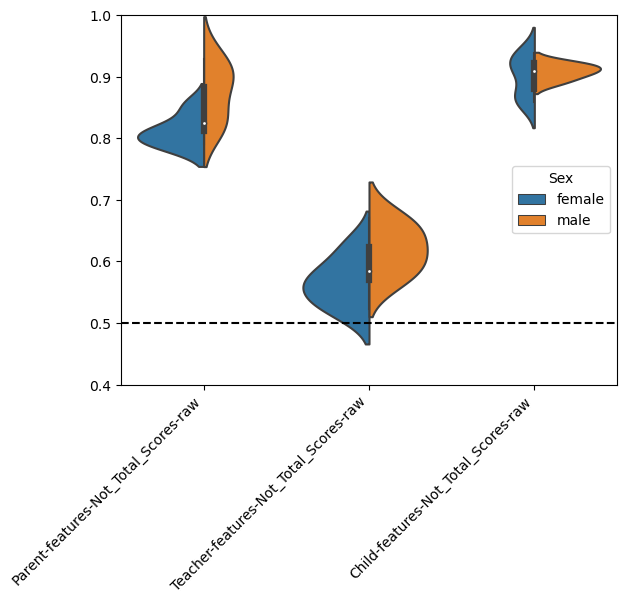

In [6]:
cols = ['clf', 'Sex', 'data', 'PreInt_Demos_Fam,Child_Race_cat', 'features', 'readers']
vals = [
    clfs, 
    ['male', 'female'], 
    ['model-null'], 
    ['all'], 
    ['Child-features-Not_Total_Scores-raw', 'Parent-features-Not_Total_Scores-raw', 'Teacher-features-Not_Total_Scores-raw'],
    ['all readers']
       ]

df_filter = filter_data(dataframe=df, columns=cols, values_list=vals)

plot_model_results(dataframe=df_filter, 
                   x='features', 
                   y='roc_auc_score', 
                   hue='Sex', 
                   split=True,
                   title=''
                  )

### No sig. difference across males and females for parent, child and teacher models

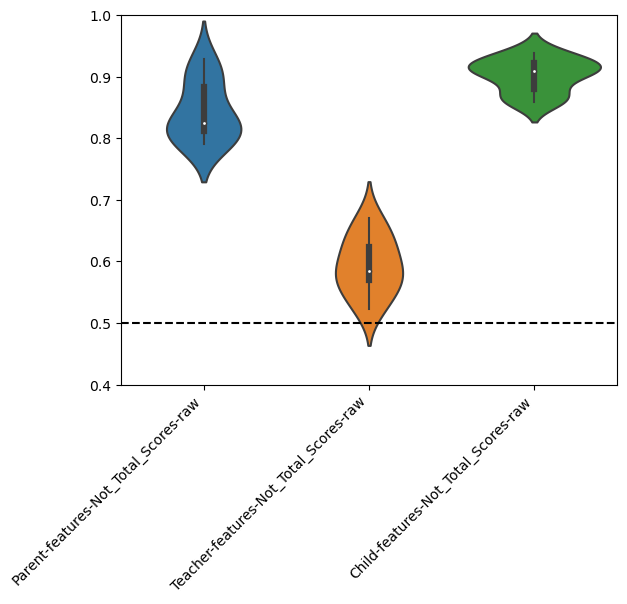

In [11]:
cols = ['clf', 'Sex', 'data', 'PreInt_Demos_Fam,Child_Race_cat', 'features', 'readers']
vals = [
    clfs, 
    ['male', 'female'], 
    ['model-null'], 
    ['all'], 
    ['Child-features-Not_Total_Scores-raw', 'Parent-features-Not_Total_Scores-raw', 'Teacher-features-Not_Total_Scores-raw'],
    ['all readers']
       ]

df_filter = filter_data(dataframe=df, columns=cols, values_list=vals)

plot_model_results(dataframe=df_filter, 
                   x='features', 
                   y='roc_auc_score', 
                   hue=None, 
                   split=False,
                   title=''
                  )

### Children outperform parents and teachers in predicting reading impairment


## Feature specific models (language vs phono etc)

* Total scores are NOT removed from these models (incls aggregate scores)
* Models are aggregated across all sexes, ages and races

* Best models:
    * language models ('CELF', 'PPVT', 'EVT', 'TOWRE')
    * achievement ('WIAT')
    * phonological ('CTOPP', 'GFTA')
    * intelligence ('WISC', 'WAIS', 'KBIT')
    * emotional status ('YSR', 'C3SR', 'SCARED_SR', 'CIS_SR', 'WHODAS_SR', 'PANAS')
    * executive function ('NIH')

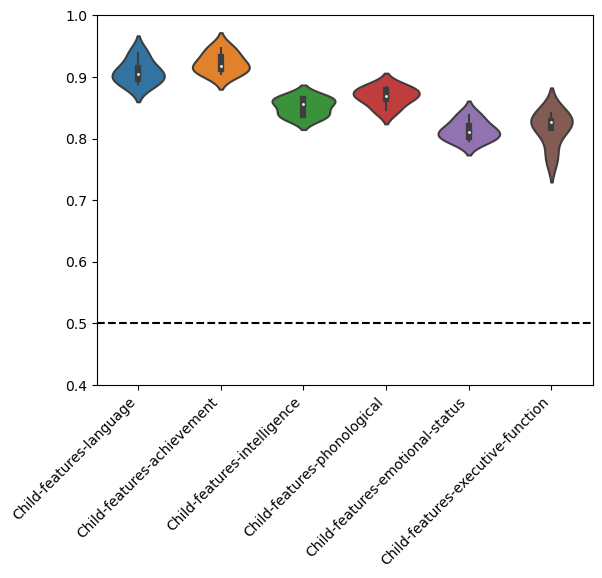

In [234]:
cols = ['clf', 'Sex', 'data', 'PreInt_Demos_Fam,Child_Race_cat', 'features', 'readers']
vals = [
    clfs, 
    ['male_female'], 
    ['model-null'], 
    ['all'], 
    ['Child-features-raw'],
    ['all readers']
       ]

df_filter = filter_data(dataframe=df, columns=cols, values_list=vals)

plot_model_results(dataframe=df_filter, 
                   x='spec_name', 
                   y='roc_auc_score', 
                   hue=None, 
                   split=False,
                   title=''
                  )

### Model prediction is greatly improved when aggregate scores are included

## Race models

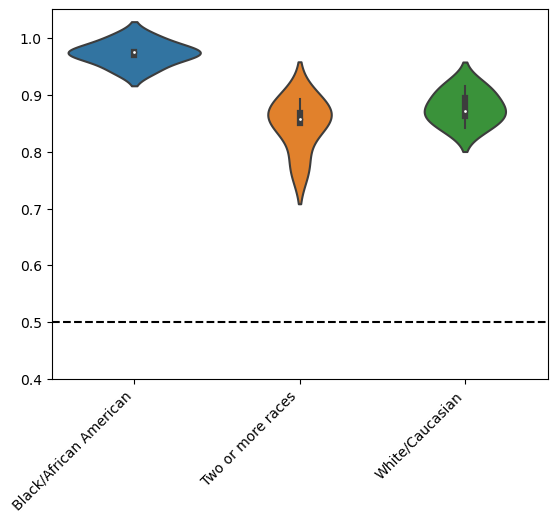

In [23]:
cols = ['clf', 'Sex', 'data', 'PreInt_Demos_Fam,Child_Race_cat', 'features', 'readers']
vals = [
    clfs, 
    ['male_female'], 
    ['model-null'], 
    race, 
    ['Child-features-Not_Total_Scores-raw'],
    ['all readers']
       ]

df_filter = filter_data(dataframe=df, columns=cols, values_list=vals)

plot_model_results(dataframe=df_filter, 
                   x='PreInt_Demos_Fam,Child_Race_cat', 
                   y='roc_auc_score', 
                   hue=None, 
                   split=False,
                   title='',
                   ylim=[0.4, 1.05]
                  )

### When models are built separately on race, Black children are better classified than White and biracial children


## Age models

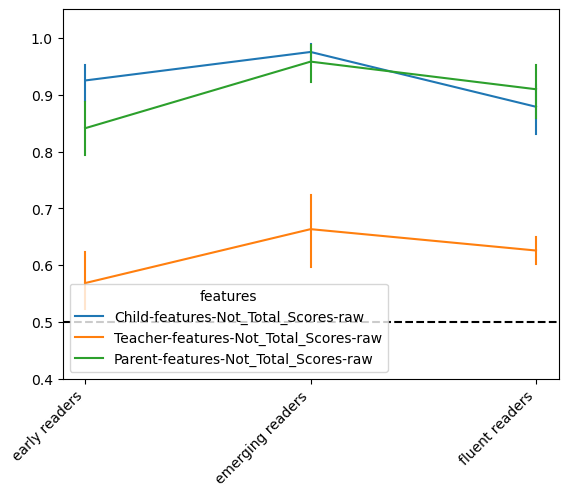

In [17]:
cols = ['clf', 'Sex', 'data', 'PreInt_Demos_Fam,Child_Race_cat', 'features', 'readers']
vals = [
    clfs, 
    ['male'], 
    ['model-null'], 
    ['all'], 
    ['Child-features-Not_Total_Scores-raw', 'Parent-features-Not_Total_Scores-raw', 'Teacher-features-Not_Total_Scores-raw'],
    ['early readers', 'emerging readers', 'fluent readers']
       ]

df_filter = filter_data(dataframe=df, columns=cols, values_list=vals)

plot_model_results(dataframe=df_filter,
                   plot_type='lineplot',
                   x='readers', 
                   y='roc_auc_score', 
                   hue='features', 
                   split=None,
                   title='',
                   ylim=[0.4, 1.05],
                   order=['early readers', 'emerging readers', 'fluent readers']
                  )


### Child and Parent models outperform teacher models across all reader groups